In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import datetime
import scipy.stats as stats
from scipy.stats import kstest
from IPython.display import Image
from IPython.core.display import HTML 

In [2]:
# import random
# p = 0.05
# flights_sample = pd.read_csv(
#         '/content/drive/My Drive/Colab Notebooks/flights.csv',
#          header=0, 
#          skiprows=lambda i: i>0 and random.random() > p)
# flights_sample.to_csv('flights_sample5pct.csv')

In [3]:
datapath = '/media/mdesk/HD Shared/LHL-coursework/Midterm/data/'
flights = pd.read_csv(datapath + 'flights_pandas_sample5pct.csv')
flights.drop(['Unnamed: 0'], axis=1,inplace=True)
passengers = pd.read_csv(datapath +'passengers.csv')
fuel = pd.read_csv(datapath +'fuel_comsumption.csv')

/home/mdesk/.conda/envs/lhl/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (26) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
date_split = flights['fl_date'].str.split('-')
date_split[:3]
flights['year'] = [x[0] for x in date_split]
flights['month'] = [x[1] for x in date_split]
flights['day'] = [x[2] for x in date_split]



#### **Task 1**: Test the hypothesis that the delay is from Normal distribution. and that **mean** of the delay is 0. Be careful about the outliers.

In [5]:
# Take sample and remove outliers
s_arr = flights.arr_delay#.sample(n=2000)
s_dep = flights.dep_delay#.sample(n=2000)
s1 = s_arr[s_arr.between(s_arr.quantile(.05), s_arr.quantile(.95))]
s2 = s_dep[s_dep.between(s_dep.quantile(.05), s_dep.quantile(.95))]

# Based on 3st.dev's
s3 = s_arr[~((s_arr -s_arr.mean()).abs() > 3*s_arr.std())]
s4 = s_dep[~((s_dep -s_dep.mean()).abs() > 3*s_dep.std())]

# add IQR here instead of just 5% and 95% quartile


In [6]:
## Check for nulls
s1.isnull().any()

False

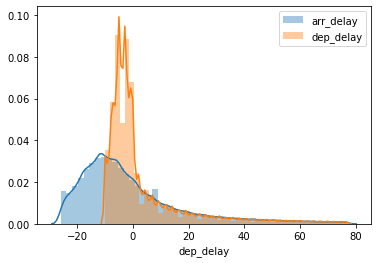

In [7]:
# Check distribution
g = sns.distplot(s1, kde=True, rug=False,label='arr_delay')
g2 = sns.distplot(s2, kde=True, rug=False, label='dep_delay')
plt.legend()

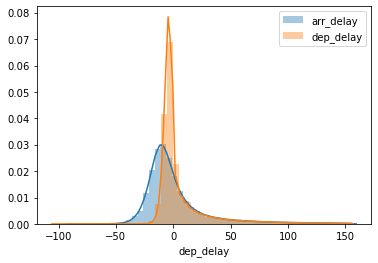

In [8]:
# Check distribution
g = sns.distplot(s3, kde=True, rug=False,label='arr_delay')
g2 = sns.distplot(s4, kde=True, rug=False, label='dep_delay')
plt.legend()

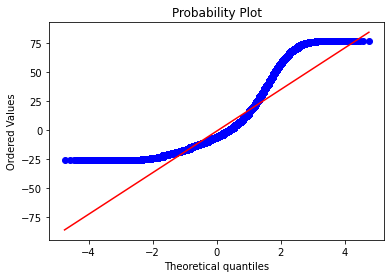

In [9]:
stats.probplot(s1, dist="norm", plot=plt)
plt.show()

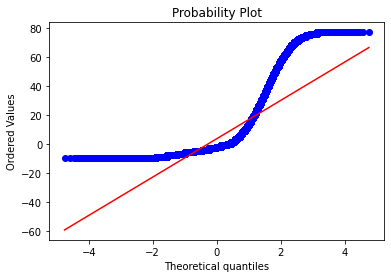

In [10]:
stats.probplot(s2, dist="norm", plot=plt)
plt.show()

In [67]:
ks_statistic, p_value = kstest(s1, 'norm',)
print("Kolmogorov–Smirnov test tests equality of distributions")
print(ks_statistic, p_value)
print('\n')
# Shapiro Test
print("Shapiro Wilkes test for normality")
print(stats.shapiro(s1))
print('\n')
print('''P value is much smaller than alpha, so we reject the null hypothesis that this came from a normal distribution''')

Kolmogorov–Smirnov test tests equality of distributions
0.598463540057871 0.0


Shapiro Wilkes test for normality
ShapiroResult(statistic=0.8584035038948059, pvalue=0.0)


P value is much smaller than alpha, so we reject the null hypothesis that this came from a normal distribution


#### **Task 2**: Is average/median monthly delay different during the year? If yes, which are months with the biggest delays and what could be the reason?

In [12]:


flights_sample_delay = flights.filter(['year','month','dep_delay','arr_delay'], axis=1)

<AxesSubplot:xlabel='month'>

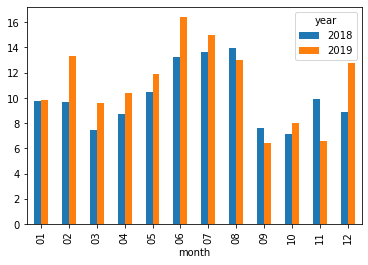

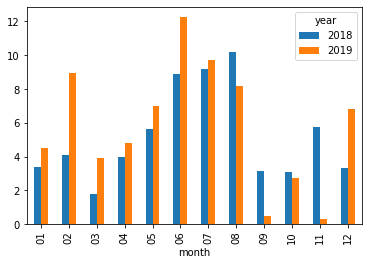

In [13]:
flights_sample_delay.groupby(['year','month'])['dep_delay'].mean().unstack('year').plot.bar()
flights_sample_delay.groupby(['year','month'])['arr_delay'].mean().unstack('year').plot.bar()

Yes, the monthly delays are different during the year. June, July , August are the months with more delays. In 2019, there is a significant delay in the month of February as well. This might be due to weather.

#### **Task 3**: Does the weather affect the delay? 
Use the API to pull the weather information for flights. There is no need to get weather for ALL flights. We can choose the right representative sample. Let's focus on four weather types:
- sunny
- cloudy
- rainy
- snow

Test the hypothesis that these 4 delays are from the same distribution. If they are not, which ones are significantly different?

In [14]:

# # https://www.visualcrossing.com/resources/documentation/weather-api/weather-api-documentation/#history

# weather_df = flights.sample(n=200)
# weather_df['weather_condition'] = ''

# import json
# import requests as re
# #jkey='T6QNR5VZUBT35SN06K0V61EFU'
# jkey='RX0UYGETLXC6UY12NGE4B1J4Z'
# chronoUnit='days'
# for i in list(range(99)):
#     location= weather_df.iloc[i].dest_city_name
#     flightdate = weather_df.iloc[i].fl_date
#     startDateTime= flightdate + 'T00:00:00'
#     endDateTime= flightdate + 'T23:59:00'


#     # time format: 2019-06-13T00:00:00
#     # 2018-05-29
#     url = f'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/weatherdata/history?&aggregateHours=24&startDateTime={startDateTime}&endDateTime={endDateTime}&unitGroup=us&contentType=json&location={location}&key={jkey}'
#     res = re.get(url)
#     print(res.text)
#     jdata = res.json()
#     weather_df['weather_condition'].iloc[i] = jdata['locations'][list(jdata['locations'])[0]]['values'][0]['conditions']

# weather_df.to_csv('/content/drive/My Drive/Colab Notebooks/weather_df.csv', mode='a', header=False)


In [15]:
weath = pd.read_csv(datapath +'weather_df.csv')
weath.weather_condition.dropna(inplace=True)
weath.weather_condition.isnull().any()

False

In [16]:
weath.weather_condition.value_counts()

Partially cloudy          67
Clear                     58
Rain, Partially cloudy    37
Rain, Overcast            10
Rain, Clear                9
Overcast                   8
Snow, Overcast             5
Snow, Clear                2
Snow, Partially cloudy     1
Name: weather_condition, dtype: int64

In [17]:
weather_dict= {
    'Partially cloudy':'cloudy',
    'Rain, Partially cloudy':'rainy',
    'Rain, Overcast':'rainy',
    'Rain, Clear':'rainy',
    'Clear':'sunny',
    'Snow, Overcast':'snow',
    'Overcast':'cloudy',
    'Snow, Clear':'snow',
    'Snow, Partially cloudy':'snow'
}
weath.weather_condition = weath.weather_condition.map(weather_dict)
weath.weather_condition.value_counts()

cloudy    75
sunny     58
rainy     56
snow       8
Name: weather_condition, dtype: int64

<AxesSubplot:xlabel='weather_condition', ylabel='dep_delay'>

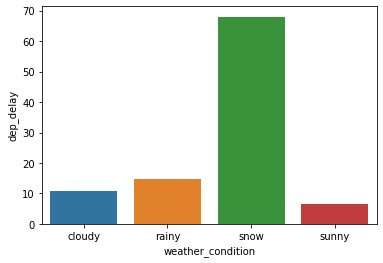

In [18]:
group = weath.groupby('weather_condition',as_index=False).mean()
sns.barplot(x = 'weather_condition', y = 'dep_delay', data = group )

# Checking Distribution of weather

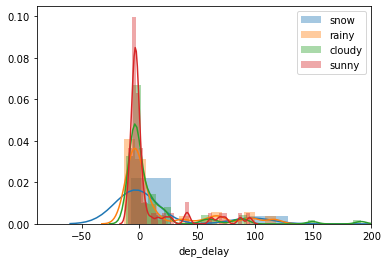

In [19]:
cond = ['snow','rainy','cloudy','sunny']
for x in cond:
  sns.distplot( weath[weath.weather_condition == x].dep_delay , label=x)
plt.xlim(None,200)
plt.legend()


In [20]:
rainy = weath[weath.weather_condition =='rainy'].dep_delay
sunny = weath[weath.weather_condition =='sunny'].dep_delay
snow = weath[weath.weather_condition =='snow'].dep_delay
cloudy = weath[weath.weather_condition =='cloudy'].dep_delay

In [21]:
from scipy import stats
print(stats.ks_2samp(rainy,sunny))
print(stats.ks_2samp(rainy,snow))
print(stats.ks_2samp(rainy,cloudy))

KstestResult(statistic=0.14963054187192118, pvalue=0.4840417101134967)
KstestResult(statistic=0.21428571428571427, pvalue=0.8649316149997042)
KstestResult(statistic=0.12547619047619046, pvalue=0.6382015607507476)


#### **Task 4**: How taxi times changing during the day? Does higher traffic lead to bigger taxi times?

In [22]:
flights_sample_taxi=flights.filter(['year','month','day','crs_dep_time','wheels_off','taxi_out','crs_arr_time','wheels_on','taxi_in'], axis=1)

In [23]:
bins = [0, 300, 600, 900, 1200, 1500, 1800, 2100, 2400]
flights_sample_taxi['binned_dep'] = np.searchsorted(bins, flights_sample_taxi['crs_dep_time'].values)
flights_sample_taxi['binned_arr'] = np.searchsorted(bins, flights_sample_taxi['crs_arr_time'].values)

In [24]:
  flights_sample_taxi= flights_sample_taxi.dropna(how='all', subset=['taxi_out', 'taxi_in'])



<AxesSubplot:title={'center':'Departure Flight traffic'}>

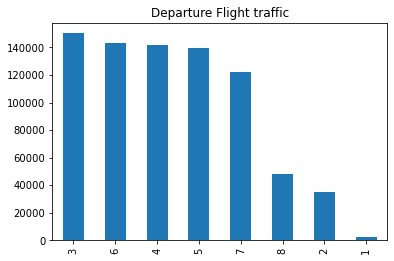

In [25]:
flights_sample_taxi['binned_dep'].value_counts().plot.bar(title='Departure Flight traffic')


<AxesSubplot:title={'center':'Arrival Flight traffic'}>

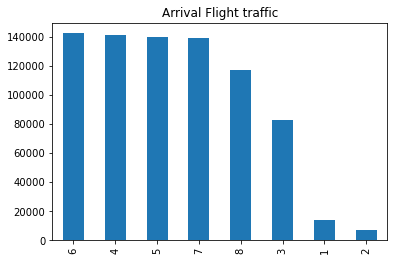

In [26]:
flights_sample_taxi['binned_arr'].value_counts().plot.bar(title='Arrival Flight traffic' )

Departure traffic is more in the bin 3 which is between 6am to 9am and Arrival traffic is almost same in the bins 4,5,6,7 which is between 9am to 9pm.

<AxesSubplot:title={'center':'Departure time and taxi out'}, xlabel='binned_dep'>

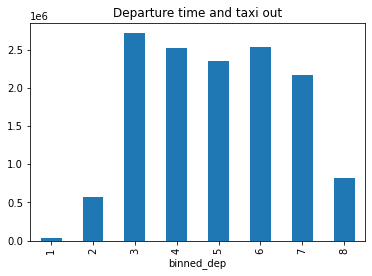

In [27]:
flights_sample_taxi.groupby(['binned_dep'])['taxi_out'].sum().plot.bar(title='Departure time and taxi out')

<AxesSubplot:title={'center':'Arrival time and taxi in'}, xlabel='binned_arr'>

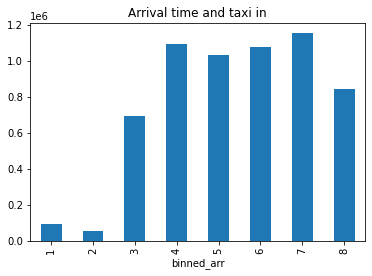

In [28]:
flights_sample_taxi.groupby(['binned_arr'])['taxi_in'].sum().plot.bar(title='Arrival time and taxi in')


The taxi in and taxi out are more when the departure arrival traffic is more. 

#### **Task 5**: What is the average percentage of delays that is already created before departure? (aka are arrival delays caused by departure delays?) Are airlines able to lower the delay during the flights?

In [29]:
df = flights[['dep_delay','arr_delay']].dropna()
df['diff'] = flights.arr_delay - flights.dep_delay
pct_delay = df[df['diff'] <=0].shape[0] / df.shape[0]
pct_other = df[df['diff'] >0].shape[0] / df.shape[0]
print(pct_delay)
print(pct_other)
# Q part 1, see result
# If they have a positive dep_delay, then which of those if dep_delya > 0 and arr_delay > 0 what are the percentages of those occurring
# Q part 2, yes, they can lower the delay during flight as many flights had a shorter arrival delay than their departure delay

0.7386800961346295
0.2613199038653705


In [30]:
''' 
When a departure is late, if a plane does not fly faster and experiences no further delay the arrival delay
will equal the departure delay and the difference will be 0.

If the plane flies faster and experiences no further delay the, the difference will be negative.

Even if other delays are occasionally experienced, if pilots have a tendency to fly faster when departing late
as the question would like us to test, then the mean value of diff for delayed flights should be smaller than the mean diff of 
flights with no delay.
'''
df.head()

,dep_delay,arr_delay,diff
0,-5.0,-22.0,-17.0
1,49.0,123.0,74.0
2,-6.0,-13.0,-7.0
3,-4.0,-21.0,-17.0
4,-5.0,-12.0,-7.0


#### **Task 6**: How many states cover 50% of US air traffic? 

In [31]:
flights_sample_states = flights.filter(['origin_airport_id','origin','origin_city_name','dest_airport_id', 'dest', 'dest_city_name','air_time','year','month'], axis=1)

In [32]:
city_split1 = flights_sample_states['origin_city_name'].str.split(',')
flights_sample_states['origin_city'] = [x[0] for x in city_split1]
flights_sample_states['origin_state'] = [x[1] for x in city_split1]
city_split2 = flights_sample_states['dest_city_name'].str.split(',')
flights_sample_states['dest_city'] = [x[0] for x in city_split2]
flights_sample_states['dest_state'] = [x[1] for x in city_split2]

In [33]:
states_2018=flights_sample_states.loc[flights_sample_states['year'] == '2018', 'origin_state'].value_counts()
states_2019=flights_sample_states.loc[flights_sample_states['year'] == '2019', 'origin_state'].value_counts()
df_states_2018=pd.DataFrame(states_2018)
df_states_2019=pd.DataFrame(states_2019)

In [34]:
df_states_2018['percentage']=df_states_2018['origin_state']*100/df_states_2018.origin_state.sum()
df_states_2019['percentage']=df_states_2019['origin_state']*100/df_states_2019.origin_state.sum()

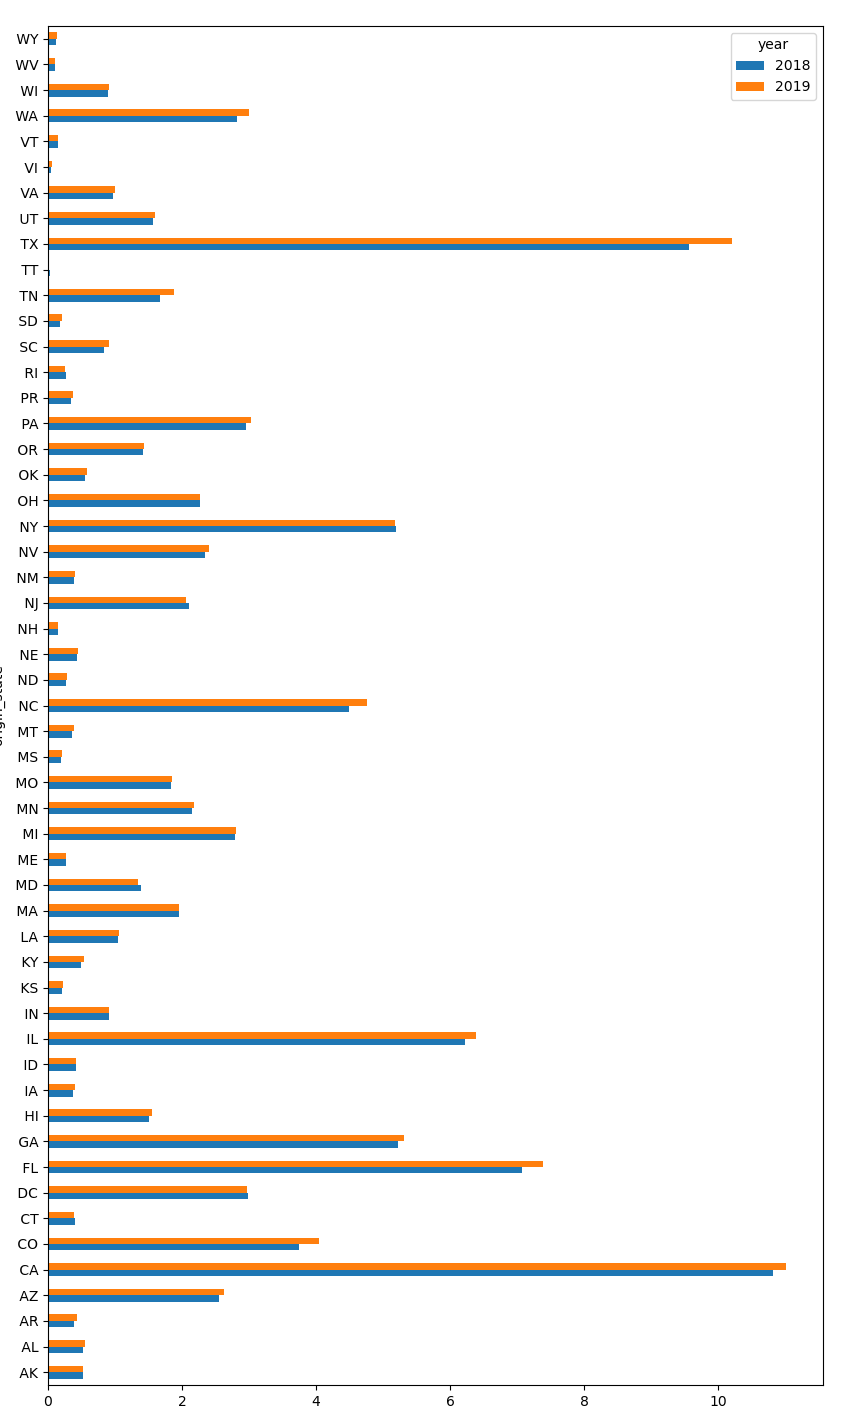

In [72]:
Image("/media/mdesk/HD Shared/LHL-coursework/Midterm/data/percent traffic by state.png")

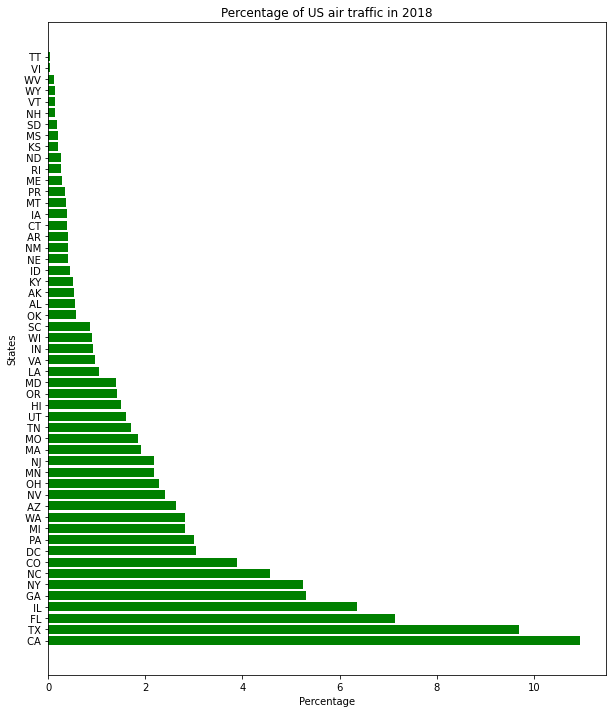

In [35]:
plt.barh(df_states_2018.index,df_states_2018.percentage,  color='green')
plt.ylabel("States")
plt.xlabel("Percentage")
plt.title("Percentage of US air traffic in 2018")
fig = plt.gcf()
fig.set_size_inches(10, 12)
fig.savefig('airtraffic2018.png', dpi=100)
plt.show()

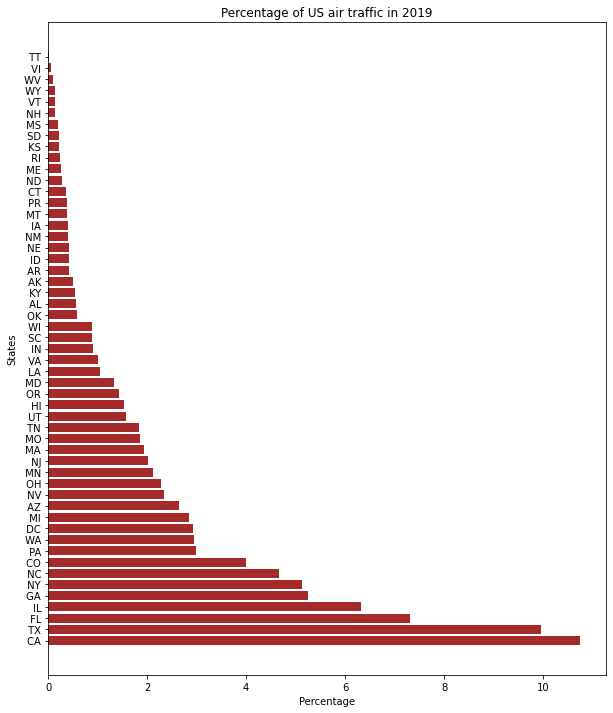

In [36]:
plt.barh(df_states_2019.index,df_states_2019.percentage,  color='brown')


plt.ylabel("States")
plt.xlabel("Percentage")
plt.title("Percentage of US air traffic in 2019")

fig = plt.gcf()
fig.set_size_inches(10, 12)
fig.savefig('airtraffic2019.png', dpi=100)

plt.show()

In [37]:
print(df_states_2018.iloc[:8].sum())
df_states_2018.iloc[:8]

origin_state    208116.000000
percentage          53.159164
dtype: float64


,origin_state,percentage
CA,42819,10.937276
TX,37969,9.698439
FL,27976,7.145922
IL,24876,6.354088
GA,20775,5.306568
NY,20570,5.254204
NC,17892,4.570162
CO,15239,3.892505


#### **Task 7**: Test the hypothesis whether planes fly faster when there is the departure delay? 

When a departure is late, if a plane does not fly faster and experiences no further delay the arrival delay
will equal the departure delay and the difference will be 0.

If the plane flies faster and experiences no further delay the, the difference will be negative.

Even if other delays are occasionally experienced, if pilots have a tendency to fly faster when departing late
as the question would like us to test, then the mean value of diff for delayed flights should be smaller than the mean diff of 
flights with no delay.

In [39]:
df = flights[['dep_delay','arr_delay']].dropna()
df['diff'] = flights.arr_delay - flights.dep_delay
# print(df.head())
no_delay = df[df.dep_delay <=0]['diff']
has_delay = df[df.dep_delay >0]['diff']

stat, p = stats.ttest_ind(no_delay.values, has_delay.values,)
print(stats.ks_2samp(no_delay,has_delay))
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')
 
 # H0 that delays and non-delays have the same mean p < alpha so there is sufficient evidence \n
 # to support the claim that has_delays has a different mean than no_delays
 



KstestResult(statistic=0.02951280885456886, pvalue=3.528425713304159e-133)
stat=-18.915, p=0.000
Probably different distributions


In [40]:
# flights['route'] = flights['origin_city_name'] + ' '+ flights['dest_city_name']
# no_delay = flights[flights.dep_delay <= 0][['air_time']]#.mean()#.plot(kind='hist',title='No Delay')
# has_delay = flights[flights.dep_delay > 0][['air_time']]#.mean()#.plot(kind='hist',title='With Delay')


#### **Task 8**: When (which hour) do most 'LONG', 'SHORT', 'MEDIUM' haul flights take off?

In [41]:
temp = flights[['air_time','dep_time']].dropna()

conditions = [temp.air_time <= 3*60,
              (temp.air_time > 3*60) & (temp.air_time <= 7*60),
              temp.air_time > 7*60]

choices = ['short_haul','medium_haul','long_haul']

temp['flight_cat'] = np.select(conditions, choices, default=0)
# with flight_cat made, don't need air_time
temp.drop('air_time',axis=1, inplace=True)
temp.dep_time = temp.dep_time.astype(int).astype(str)
def hours(x):
  if len(x) > 2:
    return int(x[:-2]) + int(x[-2:])/60 
  else:
    return int(x[-2:])/60

temp.dep_time = temp.dep_time.map(lambda x: int(hours(x)//1) )
temp.head()

,dep_time,flight_cat
0,9,short_haul
1,15,short_haul
2,6,short_haul
3,11,short_haul
4,10,short_haul


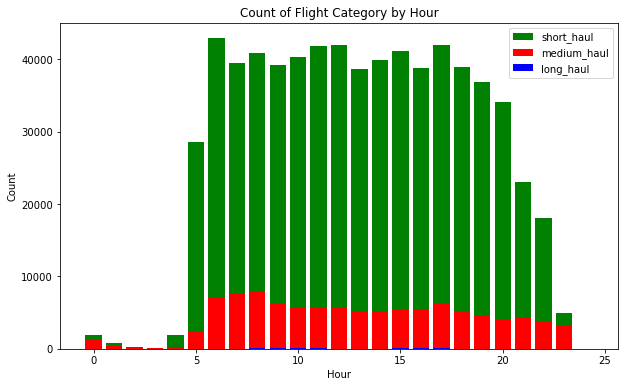

In [42]:
x1 = temp[temp.flight_cat == 'short_haul'].groupby('dep_time').count().reset_index()
x2 = temp[temp.flight_cat == 'medium_haul'].groupby('dep_time').count().reset_index()
x3 = temp[temp.flight_cat == 'long_haul'].groupby('dep_time').count().reset_index()

fig, axes = plt.subplots(figsize = (10,6)) # nrows=3, ncols=1 ,
# ax = plt.subplot(111)
axes.bar(x1.dep_time.values, x1.flight_cat.values, color='g', label='short_haul', )
axes.bar(x2.dep_time.values, x2.flight_cat.values, color='r', label='medium_haul')
axes.bar(x3.dep_time.values, x3.flight_cat.values, color='b', label='long_haul')
axes.set(title='Count of Flight Category by Hour', ylabel='Count', xlabel='Hour')
plt.legend();

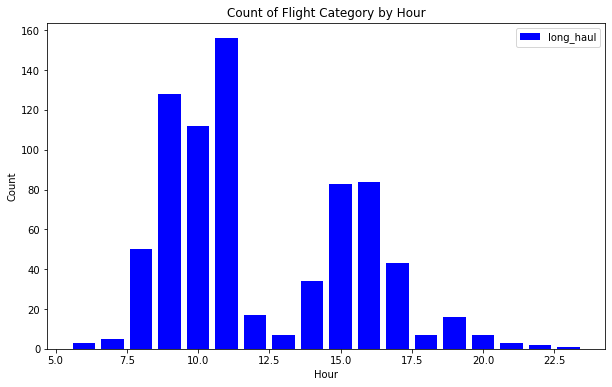

In [43]:
x3 = temp[temp.flight_cat == 'long_haul'].groupby('dep_time').count().reset_index()

fig, axes = plt.subplots(figsize = (10,6)) # nrows=3, ncols=1 ,
axes.bar(x3.dep_time.values, x3.flight_cat.values, color='b', label='long_haul')
axes.set(title='Count of Flight Category by Hour', ylabel='Count', xlabel='Hour')
plt.legend();

#### **Task 9**: Find the top 10 the bussiest airports. Does the biggest number of flights mean that the biggest number of passengers went through the particular airport? How much traffic do these 10 airports cover?

In [44]:
def busiest_airport_bypassengers(passengers_df):
  df1 = passengers_df[['passengers','origin_city_name']]
  df2 = passengers_df[['passengers','dest_city_name']]
  df1 = df1.rename(columns={'origin_city_name':'airport_city'})
  df2 = df2.rename(columns={'dest_city_name':'airport_city'})
  df3 = pd.concat((df1,df2), axis=0)
  df4 = df3.groupby('airport_city').sum().sort_values('passengers', ascending=False).reset_index()
  df4['pct_traffic'] = round(df4.passengers / passengers_df.passengers.sum(),2)
  return df4

result = busiest_airport_bypassengers(passengers)
result.head()


,airport_city,passengers,pct_traffic
0,"Atlanta, GA",515300223,0.10
1,"Chicago, IL",498550393,0.10
2,"New York, NY",447451637,0.09
3,"Los Angeles, CA",410933768,0.08
4,"Dallas/Fort Worth, TX",328157387,0.07


In [45]:
def busiest_airport_byflights(flights_df):
  df1 = flights_df[['origin_city_name']]
  df2 = flights_df[['dest_city_name']]
  df1 = df1.rename(columns={'origin_city_name':'airport_city'})
  df2 = df2.rename(columns={'dest_city_name':'airport_city'})
  df3 = pd.concat((df1,df2), axis=0)
  df3 = df3['airport_city'].value_counts().reset_index().rename(columns={'index':'airport_city','airport_city':'num_flights'})
  df3['pct_traffic'] = round(df3.num_flights / len(flights_df),2)
  return df3.sort_values('num_flights',ascending=False)

result = busiest_airport_byflights(flights)
result.head()

,airport_city,num_flights,pct_traffic
0,"Chicago, IL",96328,0.12
1,"Atlanta, GA",78732,0.10
2,"New York, NY",59779,0.08
3,"Dallas/Fort Worth, TX",58612,0.07
4,"Denver, CO",55584,0.07


#### **Task 10**: Do bigger delays lead to bigger fuel comsumption per passenger? 
We need to do four things to answer this as accurate as possible:
- Find out average monthly delay per air carrier (monthly delay is sum of all delays in 1 month)
- Find out distance covered monthly by different air carriers
- Find out number of passengers that were carried by different air carriers
- Find out total fuel consumption per air carrier.

Use this information to get the average fuel comsumption per passenger per km. Is this higher for the airlines with bigger average delays?

In [46]:
total_monthly_passengers_per_carrier = passengers[passengers.year.isin([2018, 2019])].groupby('unique_carrier').sum()['passengers']
passengers.unique_carrier.unique().shape

(377,)

In [47]:
tot_monthly_fuel_per_carrier = fuel[fuel.year.isin([2018, 2019])].groupby('unique_carrier').sum()['total_gallons']
# rows are less than  fuel.unique_carrier.unique() likely because there are carriers that only flew in other years than the ones we've selected. 

In [48]:
carrier=flights.filter(['op_unique_carrier','dep_delay','arr_delay','month'], axis=1)
carrier.rename(columns={'op_unique_carrier':'carrier','arr_delay':'delay'},inplace=True)
air_carrier_delay=pd.DataFrame(carrier.groupby(['carrier','month'])['delay'].mean())
# Delay used is only Arrival Delay as that would include the Departure Delay


In [49]:
# carrier.groupby(['carrier','month'])['delay'].mean().unstack('month').plot.bar(width=1)
# fig = plt.gcf()
# fig.set_size_inches(20, 10)
# fig.savefig('carrier.png', dpi=100)



In [50]:
distance=flights.filter(['op_unique_carrier','distance','month'])
distance.rename(columns={'op_unique_carrier':'carrier'},inplace=True)
carrier_distance=pd.DataFrame(distance.groupby(['carrier','month'])['distance'].sum())
carrier_distance.head()

distance
carrier month          
9E      01       870241
        02       861332
        03      1019066
        04       995050
        05       945937

In [51]:
# carrier_distance.groupby(['carrier','month'])['distance'].sum().unstack('month').plot.bar(width=1)
# fig = plt.gcf()
# fig.set_size_inches(20, 10)
# fig.savefig('distance.png', dpi=100)

In [52]:
h1 = total_monthly_passengers_per_carrier.reset_index()


In [53]:
h2 = tot_monthly_fuel_per_carrier.reset_index()
h3 = h2.merge(h1, how='left',on='unique_carrier')
h3.rename(columns={'unique_carrier':'carrier'}, inplace=True)
carrierlist = h3.carrier.to_list()


In [54]:
h4 = carrier_distance.reset_index()
h4 = h4[h4.carrier.isin(carrierlist)]
h5 = h4.merge(h3, how='left',on='carrier')
h5 = h5[h5.total_gallons !=0]
h5['avg_gall_pass_km'] = h5.total_gallons / h5.passengers  / h5.distance
h5.head()


,carrier,month,distance,total_gallons,passengers,avg_gall_pass_km
12,AA,01,7643305,6.416096e+09,304746529,0.000003
13,AA,02,6884494,6.416096e+09,304746529,0.000003
14,AA,03,7981398,6.416096e+09,304746529,0.000003
15,AA,04,7397107,6.416096e+09,304746529,0.000003
16,AA,05,7822480,6.416096e+09,304746529,0.000003


In [55]:
h5['carrier_month'] = h5.carrier + h5.month.astype(str)
h5.head()

,carrier,month,distance,total_gallons,passengers,avg_gall_pass_km,carrier_month
12,AA,01,7643305,6.416096e+09,304746529,0.000003,AA01
13,AA,02,6884494,6.416096e+09,304746529,0.000003,AA02
14,AA,03,7981398,6.416096e+09,304746529,0.000003,AA03
15,AA,04,7397107,6.416096e+09,304746529,0.000003,AA04
16,AA,05,7822480,6.416096e+09,304746529,0.000003,AA05


In [56]:
h6 = air_carrier_delay.reset_index()
h6['carrier_month'] = h6.carrier + h6.month.astype(str)
h6.head()

,carrier,month,delay,carrier_month
0,9E,01,3.219540,9E01
1,9E,02,6.422414,9E02
2,9E,03,3.366265,9E03
3,9E,04,7.745499,9E04
4,9E,05,0.199005,9E05


In [57]:
h7 = h6.merge(h5,how='left',on='carrier_month').dropna()
h7.head()

,carrier_x,month_x,delay,carrier_month,carrier_y,month_y,distance,total_gallons,passengers,avg_gall_pass_km
17,AA,01,2.211213,AA01,AA,01,7643305.0,6.416096e+09,304746529.0,0.000003
18,AA,02,3.980982,AA02,AA,02,6884494.0,6.416096e+09,304746529.0,0.000003
19,AA,03,2.336552,AA03,AA,03,7981398.0,6.416096e+09,304746529.0,0.000003
20,AA,04,3.859750,AA04,AA,04,7397107.0,6.416096e+09,304746529.0,0.000003
21,AA,05,9.435716,AA05,AA,05,7822480.0,6.416096e+09,304746529.0,0.000003


In [58]:
h8 = h7[['carrier_x','month_x','delay','avg_gall_pass_km']]
h8.head()

,carrier_x,month_x,delay,avg_gall_pass_km
17,AA,01,2.211213,0.000003
18,AA,02,3.980982,0.000003
19,AA,03,2.336552,0.000003
20,AA,04,3.859750,0.000003
21,AA,05,9.435716,0.000003


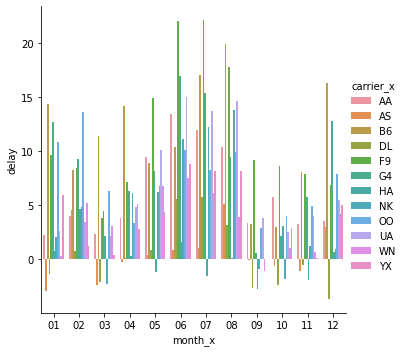

In [59]:
g = sns.catplot(x="month_x",y="delay",kind='bar',hue='carrier_x',order=['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12'],ci=False,data=h8)

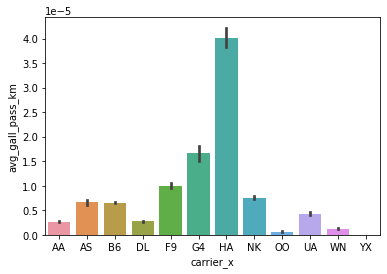

In [60]:
ax2 = sns.barplot(data = h8, x='carrier_x',y='avg_gall_pass_km')

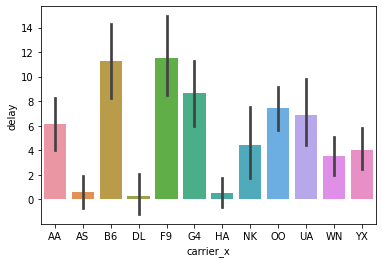

In [61]:
ax = sns.barplot(data = h8, x='carrier_x',y='delay')

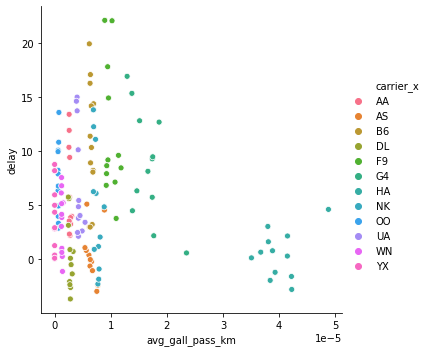

In [62]:
g = sns.relplot(x="avg_gall_pass_km",y="delay",hue='carrier_x',kind='scatter',data=h8)

In [63]:
# g = sns.relplot(x="avg_gall_pass_km",y="delay",col='carrier_x',kind='scatter',data=h8, col_wrap=True)

In [64]:
flights.shape

(796370, 45)

# End EDA